# Ejercicio Complementario 4 - Detección Visual de Objetos en Visión Computacional con YOLO

Este ejercicio aborda el uso de un modelo pre-entrenado de detección de objetos en imágenes, para aprender la forma de utilización y su uso práctico.

## Contexto: Análisis de imágenes

La visión computacional es una rama de la ciencia de la computación, que se enfoca en el procesamiento de imágenes, particularmente buscando interpretar su contenido para usos prácticos. En particular, la detección de objetos es una característica útil en contextos de necesidad de contar ciertos tipos de objetos y/o generar alertas de presencia de elementos específicos en una fuente de imágenes.

**YOLO - You Only Look Once**

https://pjreddie.com/darknet/yolo/

YOLO es un modelo que combina diferentes clasificadores, que reciben pixeles de una imagen, para entregar una clasificación. Un primer clasificador analiza diversas recuadros de pixeles para determinar si hay un objeto digno de analizarse, pasándole esos pixeles al segundo clasificador, capaz de determinar el tipo de objeto del recuadro.

En particular, este ejemplo utiliza fuentes de https://github.com/bnosac/image/tree/master/image.darknet, que es un wrapper (un adaptador) del código original, para ser utilizado desde R, con limitaciones de acceder a la información interna que YOLO entrega en la interpretación de las imágenes. Por ello, este módulo muestra una imagen resultante con los recuadros y etiquetas de objetos identificados, sin que se pueda acceder a estos datos en detalle. Esto se puede hacer con más facilidad en Python.



Esta adaptación en particular, por el equipo de R:Solver (RSolver.com), se comparte como un ejercicio de aprendizaje dentro de los cursos de Big Data y Machine Learning.


---


## Instrucciones Generales

El objetivo es lograr procesar imágenes. Se incluyen imágenes de ejemplo, pero la idea es que el usuario pueda cambiarlas y analizar algunas propias, buscando detectar los objetos más relevantes. En esa línea, la sección final interpreta el resultado obtenido por el modelo, generando una copia de la imagen original con los recuadros y objetos detectados.

Se espera que el usuario suba sus propias imágenes a su carpeta "content" en este Notebook de Google Colab y ejecute el amálisis de YOLO sobre esas imágenes, viendo el resultado. Opcionalmente se puede variar la tasa mínima de detección de un objeto para ser considerado (threshold) subiéndolo a 0.8 o más y ver cómo algunos objetos que antes se reconocían, ahora no se marcan en YOLO, por no cumplir con esa tasa de claridad mínima.




## Base: Instalar las librerías de modelos y funciones necesarias

Esto se ejecuta sólo una vez al comienzo de la sesión de cada persona. No se necesita volver a ejecutar con cada nueva prueba del resto de los scripts.

In [ ]:
install.packages("png")
install.packages("jpeg")
install.packages("devtools")
devtools::install_github("bnosac/image", subdir = "image.darknet", build_vignettes = TRUE)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘httpuv’, ‘xtable’, ‘fontawesome’, ‘sourcetools’, ‘later’, ‘promises’, ‘textshaping’, ‘shiny’, ‘downlit’, ‘ragg’, ‘htmlwidgets’, ‘miniUI’, ‘pkgdown’, ‘profvis’, ‘roxygen2’, ‘urlchecker’


Warning message in install.packages("devtools"):
“installation of package ‘textshaping’ had non-zero exit status”
Warning message in install.packages("devtools"):
“installation of package ‘ragg’ had non-zero exit status”
Warning message in install.packages("devtools"):
“installation of package ‘pkgdown’ had non-zero exit status”
Warning message in install.packages("devtools"):
“installation of package ‘devtools’ had non-zero exit status”



* checking for file ‘/tmp/RtmpBFXDSq/remotes3c7397f799/bnosac-image-1dd70d0/image.darknet/DESCRIPTION’ ... OK
* preparing ‘image.darknet’:
* checking DESCRIPTION meta-information ... OK
* cleaning src
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘image.darknet_0.1.0.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## Base: Cargar archivos de referencia

Se carga la lista de objetos para YOLO y también 2 fotos como ejemplos. Esto basta con ejecutarlo una sola vez. Nótese que los archivos respectivos quedan guardados en la carpeta local /content/ de la sesión en Google Colab y se borran cuando la sesión se cierra.

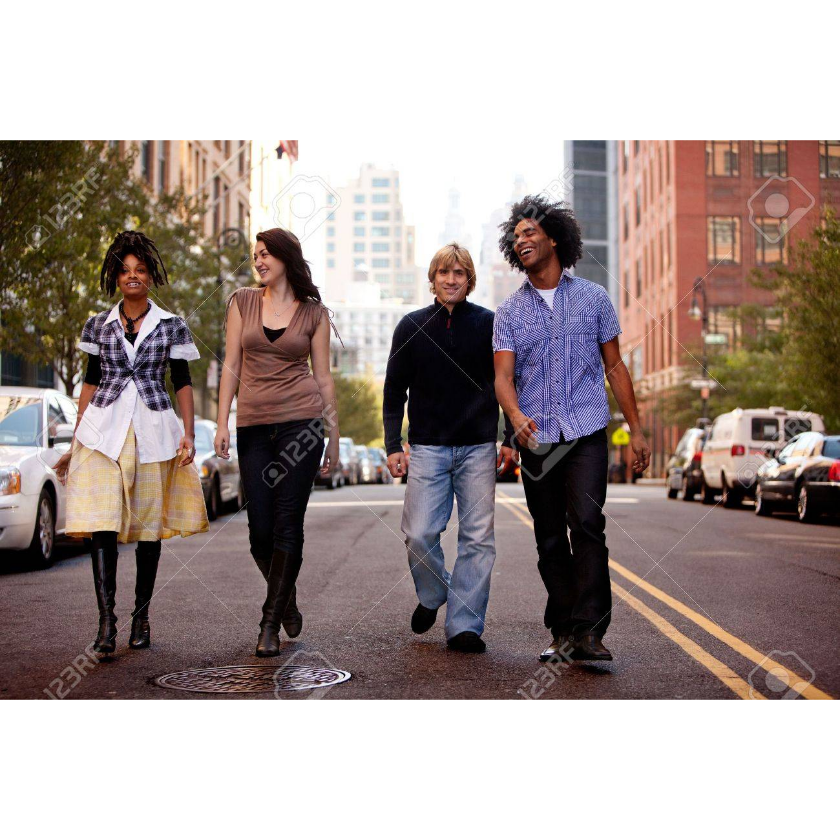

In [ ]:
# Lista de nombres en español para YOLO Tiny
labelsURL <- "http://www.rsolver.com/dcc/docs/yolo.tiny.names.txt"
download.file(url=labelsURL, destfile="/content/yolo.tiny.labels.txt")

# Dos fotos de ejemplo
foto1URL <- "http://www.rsolver.com/dcc/docs/people-on-street.jpg"
download.file(url=foto1URL, destfile="/content/people-street.jpg")
foto2URL <- "http://www.rsolver.com/dcc/docs/people-in-office.jpg"
download.file(url=foto2URL, destfile="/content/people-office.jpg")

# Se muestra la primera imagen, como referencia
library(jpeg)
img <- readJPEG("/content/people-street.jpg")
grid::grid.raster(img)


## Paso 1: Carga del Modelo YOLO

La siguiente código carga una versión liviana de YOLO, para usarla en forma experimental.

Esto también puede ser ejecutado una sola vez, si es conveniente.

In [ ]:
library(image.darknet)

yolo_model <- image_darknet_model(type = 'detect',
                            model = "tiny-yolo-voc.cfg",
                            weights = system.file(package="image.darknet", "models", "tiny-yolo-voc.weights"),
                            labels = "/content/yolo.tiny.labels.txt")

# Se muestran las características del modelo (se ven capas convolucionales, entre otros)
print(yolo_model)

Darknet model
  number of labels: 20
  example labels: avion, bicicleta, pajaro, bote, botella, bus, auto, gato, silla, vaca
Darknet model structure
[net]
batch=64
subdivisions=8
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
max_batches = 40100
policy=steps
steps=-1,100,20000,30000
scales=.1,10,.1,.1

[convolutional]
batch_normalize=1
filters=16
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=512
size=3
st

## Paso 2: Uso de YOLO para analizar imágenes

Los siguientes 2 bloques de código analizan 2 imágenes diferentes, entregando y desplegando los resultados respectivos.

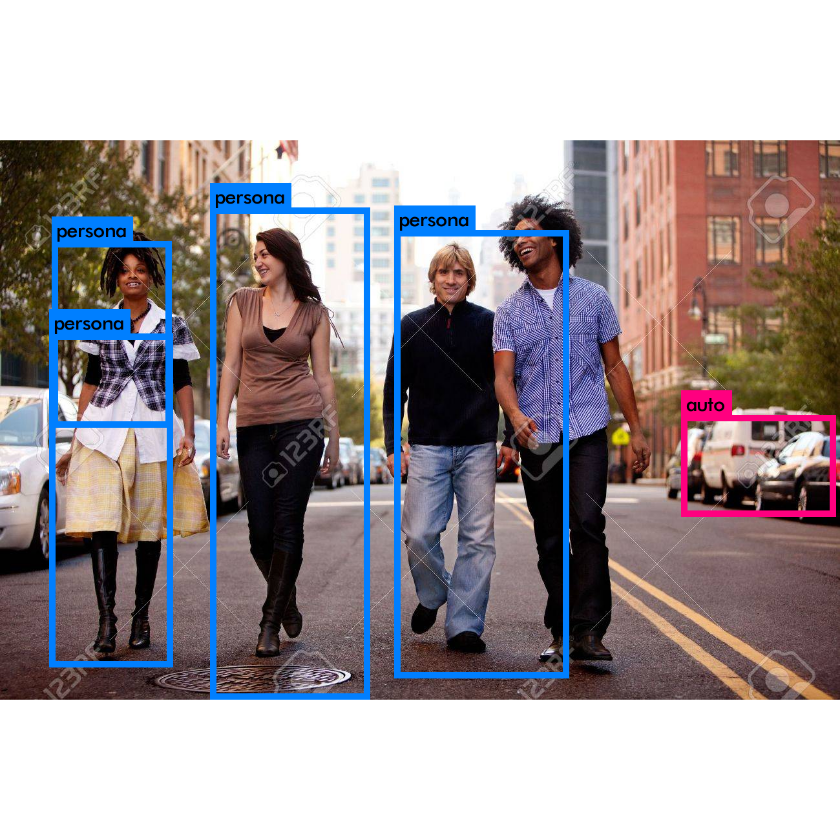

In [ ]:
library(png)

threshold = 0.4 # Tasa mínima de detección de un objeto. Se puede variar y ver el efecto.
hier_threshold = 0.5

imagefile1 = "/content/people-street.jpg"  # Se puede usar otro nombre de archivo subido por el usuario
result <- .Call("darknet_detect",
                  yolo_model$cfgfile,
                  yolo_model$weightfile,
                  imagefile1,
                  threshold, hier_threshold,
                  yolo_model$labels,
                  system.file(package = "image.darknet", "include", "darknet"),
                  PACKAGE = "image.darknet")

img <- readPNG("/content/predictions.png")
grid::grid.raster(img)


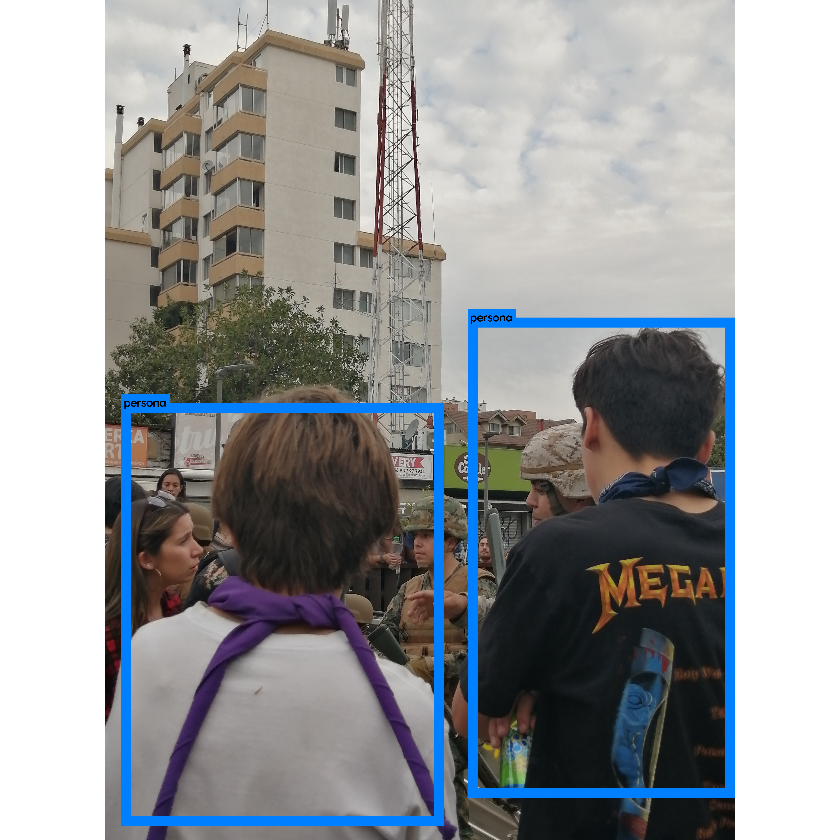

In [ ]:
library(png)

threshold = 0.40 # Tasa mínima de detección de un objeto. Se puede variar y ver el efecto.
hier_threshold = 0.5

imagefile2 = "/content/Foto02.jpg"
result <- .Call("darknet_detect",
                  yolo_model$cfgfile,
                  yolo_model$weightfile,
                  imagefile2,
                  threshold, hier_threshold,
                  yolo_model$labels,
                  system.file(package = "image.darknet", "include", "darknet"),
                  PACKAGE = "image.darknet")

img <- readPNG("/content/predictions.png")
grid::grid.raster(img)